In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import joblib
import numpy as np
import re
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

## Data Cleaning

In [2]:
# Load the dataset
data_path = 'data/song_lyrics.csv'
df = pd.read_csv(data_path)

In [3]:
# checking
print(df.shape, '\n', '-' * 80)
print(df.isnull().sum(), '\n', '-' * 80)
df.head()

(5134856, 11) 
 --------------------------------------------------------------------------------
title               188
tag                   0
artist                0
year                  0
views                 0
features              0
lyrics                0
id                    0
language_cld3     90966
language_ft      134322
language         226918
dtype: int64 
 --------------------------------------------------------------------------------


,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en


In [4]:
# Filter rows where the language is 'en'
df['language'].unique()
df = df[df['language'] == 'en']
df['language'].unique()

# checking
print(df.shape)
df.head()

(3374198, 11)


,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en


In [5]:
# Filter rows with misc (undefined) tags
df['tag'].unique()
df = df[df['tag'] != 'misc']
df['tag'].unique()

# checking
print(df.shape)
df.head()

(3233212, 11)


,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en


In [6]:
# Keep only necessary columns: 'lyrics' and 'tag'
df = df[['lyrics', 'tag']]

# checking
print(df.shape)
print(df.isnull().sum())
df.head()

(3233212, 2)
lyrics    0
tag       0
dtype: int64


,lyrics,tag
0,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",rap
1,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",rap
2,Maybe cause I'm eatin\nAnd these bastards fien...,rap
3,[Produced by Kanye West and Brian Miller]\n\n[...,rap
4,"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",rap


In [7]:
# Checking percentage of each unique value in the tags
print(df.shape)
print(df['tag'].value_counts(normalize=True) * 100)

(3233212, 2)
tag
pop        43.101380
rap        29.834264
rock       19.587580
rb          4.796531
country     2.680245
Name: proportion, dtype: float64


Reducing dataset's size, for ease of processing

In [8]:
# Reducing option 1:
# Stratified sampling to reduce the dataset to 300k examples (reducing the data while preserving the same genre distribution)
df_reduced, _ = train_test_split(df, train_size=300000, stratify=df['tag'], random_state=77)


In [ ]:
# Reducing option 2:
# (the first option performs better)
# Downsample dataset to balance classes
def downsample_dataset(df, target_size):
    """
    Downsample the dataset to balance classes and reduce size.

    Args:
        df (DataFrame): Original dataset.
        target_size (int): Desired total size of the dataset.

    Returns:
        DataFrame: Reduced and balanced dataset.
    """
    # Determine target size per class
    num_classes = df['tag'].nunique()
    target_per_class = target_size // num_classes

    # Downsample each class
    df_balanced = df.groupby('tag').apply(lambda x: x.sample(n=min(len(x), target_per_class), random_state=42)).reset_index(drop=True)
    return df_balanced

# Reduce dataset size
reduced_size = 200000  # Specify desired dataset size
df_reduced = downsample_dataset(df, reduced_size)


In [9]:
# checking data after reducing
print(df_reduced.shape)
print(df_reduced['tag'].value_counts(normalize=True) * 100)
df_reduced.head()

(300000, 2)
tag
pop        43.101333
rap        29.834333
rock       19.587667
rb          4.796333
country     2.680333
Name: proportion, dtype: float64


,lyrics,tag
2379187,The fog of confusion is melting away\nWith a c...,rock
2884289,"[Intro]\n\nDexter, they going out sad\n\n[Pre-...",rap
4602322,[Verse]\nI've been rhyming every day (I have)\...,rap
2091379,"[Verse 1]\nBroken, bruised and burned\nBut the...",pop
4767180,Come take this badge off of me\nI can't wear i...,rock


In [10]:
# Load custom stopwords from stopwords.txt
def load_custom_stopwords(filepath):
    with open(filepath, 'r') as file:
        stopwords_set = set(line.strip().lower() for line in file)
    return stopwords_set

# Path to stopwords.txt
stopwords_path = 'data/stopwords/english'
custom_stopwords = load_custom_stopwords(stopwords_path)

# checking
print(len(custom_stopwords))

214


In [11]:
# Data cleaning function
def normalize(text):
    text = text.lower()
    # remove singing noises
    text = re.sub(r'\bm+\b', ' ', text)
    text = re.sub(r'\bo+h+\b', ' ', text)
    text = re.sub(r'\ba+h+\b', ' ', text)
    text = re.sub(r'\bh+m+\b', ' ', text)
    text = re.sub(r'\by+o+\b', ' ', text)
    text = re.sub(r'\bo+y+\b', ' ', text)
    text = re.sub(r'\bg+o+\b', ' ', text)
    text = re.sub(r'\bu+m+\b', ' ', text)

    # normalize unnecessary repeated characters
    text = re.sub(r'\bo+n+\b', ' on ', text)
    text = re.sub(r'\bn+o+\b', ' no ', text)
    text = re.sub(r'\bn+o+w+\b', ' now ', text)
    text = re.sub(r'\by+o+u+\b', ' you ', text)
    text = re.sub(r'\by+e+a+h+\b', ' yeah ', text)
    text = re.sub(r'\bb+a+b+y+\b', ' baby ', text)
    text = re.sub(r'\bw+a+n+t+\b', ' want ', text)
    text = re.sub(r'\bt+r+u+s+t+\b', ' trust ', text)

    # correct some misspelled words
    text = re.sub(r'\bl+u+v+\b', ' love ', text)
    text = re.sub(r'\bl+o+v+\b', ' love ', text)

    return text

def clean_text(text):
    text = re.sub(r'\[.*?\]', ' ', text)  # Removes text between brackets
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Removes everything except letters and spaces

    # Remove stopwords
    words = text.strip().split()
    stop_words = set(word.lower() for word in custom_stopwords)
    filtered_words = [word for word in words if word not in stop_words]

     # Remove words of length 1 or 2
    filtered_words = [word for word in filtered_words if len(word) > 2]

    # Lemmatize words
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    return ' '.join(lemmatized_words) # Join the filtered words back into a single string


In [12]:
# apply cleaning function to our data
df_reduced['lyrics'] = df_reduced['lyrics'].apply(normalize)
print('done normalizing')
print(df_reduced.head())

df_reduced['lyrics'] = df_reduced['lyrics'].apply(clean_text)
print('done cleaning')
print(df_reduced.head())

done normalizing
                                                    lyrics   tag
2379187  the fog of confusion is melting away\nwith a c...  rock
2884289  [intro]\n\ndexter, they going out sad\n\n[pre-...   rap
4602322  [verse]\ni've been rhyming every day (i have)\...   rap
2091379  [verse 1]\nbroken, bruised and burned\nbut the...   pop
4767180  come take this badge off of me\ni can't wear i...  rock
done cleaning
                                                    lyrics   tag
2379187  fog confusion melting away clear mind life fre...  rock
2884289  dexter going sad tell realest tell great seein...   rap
4602322  rhyming every day majesty glad see strategy fa...   rap
2091379  broken bruised burned lesson never learned twi...   pop
4767180  come take badge wear getting dark see feel lik...  rock


In [13]:
# Save the DataFrame in binary format, after normalizing & cleaning
df_reduced.to_parquet('data/cleaned_songs_dataset.parquet', index=False)

In [14]:
# testing cleaning function
test_text = "mmmmMm MMmmm Ohhh no! I can't believe it ... Baby, you're amazing! 😍😍 123 yeaaaah YYeeah babies\nlove"
# test_text = "babe baby babies"
# test_text = df['lyrics'][90]


test_text_normalized = normalize(test_text)
print(f'normalized text:\n{test_text_normalized}')

test_text_normalized_cleaned = clean_text(test_text_normalized)
print(f'cleaned text:\n{test_text_normalized_cleaned}')

normalized text:
       no ! i can't believe it ...  baby ,  you 're amazing! 😍😍 123  yeah   yeah  babies
love
cleaned text:
believe baby amazing yeah yeah baby love


In [15]:
# Tokenization: split lyrics into lists of words
def tokenize_text(text):
    tokens = text.split()
    return tokens

df_reduced['tokens'] = df_reduced['lyrics'].apply(tokenize_text)  # Tokenize cleaned lyrics
print(df_reduced.shape)
df_reduced.head()

(300000, 3)


,lyrics,tag,tokens
2379187,fog confusion melting away clear mind life fre...,rock,"[fog, confusion, melting, away, clear, mind, l..."
2884289,dexter going sad tell realest tell great seein...,rap,"[dexter, going, sad, tell, realest, tell, grea..."
4602322,rhyming every day majesty glad see strategy fa...,rap,"[rhyming, every, day, majesty, glad, see, stra..."
2091379,broken bruised burned lesson never learned twi...,pop,"[broken, bruised, burned, lesson, never, learn..."
4767180,come take badge wear getting dark see feel lik...,rock,"[come, take, badge, wear, getting, dark, see, ..."


## Features

In [16]:
# handcrafted features
def count_baby_occurrences(text):
    return text.split().count('baby')

def average_word_length(text):
    words = text.split()
    return np.mean([len(word) for word in words]) if words else 0

def count_words(text):
    return len(text.split())


# applying handcrafted features
df_reduced['baby_count'] = df_reduced['lyrics'].apply(count_baby_occurrences)  # Count occurrences of 'baby'
df_reduced['avg_word_length'] = df_reduced['lyrics'].apply(average_word_length)  # Calculate average word length
df_reduced['word_count'] = df_reduced['lyrics'].apply(count_words)  # Count the total number of words

# checking
print(df_reduced.shape)
df_reduced.head()

(300000, 6)


,lyrics,tag,tokens,baby_count,avg_word_length,word_count
2379187,fog confusion melting away clear mind life fre...,rock,"[fog, confusion, melting, away, clear, mind, l...",0,6.147059,68
2884289,dexter going sad tell realest tell great seein...,rap,"[dexter, going, sad, tell, realest, tell, grea...",0,5.174538,487
4602322,rhyming every day majesty glad see strategy fa...,rap,"[rhyming, every, day, majesty, glad, see, stra...",0,5.578680,394
2091379,broken bruised burned lesson never learned twi...,pop,"[broken, bruised, burned, lesson, never, learn...",0,5.085106,94
4767180,come take badge wear getting dark see feel lik...,rock,"[come, take, badge, wear, getting, dark, see, ...",0,5.169014,71


In [17]:
# check if baby_count is correlated with specific genres
print(df_reduced.groupby('tag')['baby_count'].mean())

tag
country    0.571446
pop        0.595364
rap        0.597354
rb         1.962054
rock       0.260981
Name: baby_count, dtype: float64


In [18]:
# Enhanced Word2Vec Vectorization
sentences = df_reduced['tokens'].tolist()  # Convert tokens column to a list of sentences (lists of words)
w2v_model = Word2Vec(sentences, vector_size=250, window=6, min_count=3, workers=8, seed=77, sg=1,)  # Train Word2Vec model with optimized parameters

print('done training Word2Vec model')

done training Word2Vec model


In [19]:
# Save the trained Word2Vec model to a file
w2v_model.save("models/word2vec_model.model")

In [20]:
# checking Word2Vec model

# Get all unique words in the model's vocabulary
vocabulary = w2v_model.wv.index_to_key
print(vocabulary[:50])

# Get the total number of words in the vocabulary
vocab_size = len(vocabulary)
print(f"Vocabulary size: {vocab_size}")

# Get the count of occurrences for a specific word
word = 'baby'
word_count = w2v_model.wv.get_vecattr(word, "count")
print(f"'{word}' occurred {word_count} times in the training data.")

# Find words most similar to 'baby'
similar_words = w2v_model.wv.most_similar('book', topn=10)
print(similar_words)

# Calculate similarity between two words
word_one = 'love'
word_two = 'hate'
similarity = w2v_model.wv.similarity(word_one, word_two)
print(f"Similarity between {word_one} and {word_two}: {similarity}")


['like', 'know', 'got', 'get', 'love', 'yeah', 'time', 'see', 'one', 'never', 'let', 'make', 'want', 'nigga', 'back', 'say', 'come', 'cause', 'feel', 'way', 'take', 'wanna', 'life', 'bitch', 'need', 'baby', 'shit', 'day', 'fuck', 'right', 'man', 'tell', 'keep', 'think', 'girl', 'give', 'night', 'away', 'thing', 'heart', 'still', 'gonna', 'look', 'mind', 'eye', 'said', 'good', 'every', 'world', 'always']
Vocabulary size: 98298
'baby' occurred 178611 times in the training data.
[('pageless', 0.6816825270652771), ('read', 0.6389986276626587), ('page', 0.6210950613021851), ('reading', 0.5996007919311523), ('bible', 0.5884202122688293), ('chapter', 0.5754715204238892), ('library', 0.5507932901382446), ('bookworm', 0.5461357831954956), ('footnote', 0.543941080570221), ('notebook', 0.5409099459648132)]
Similarity between love and hate: 0.443111389875412


In [21]:
# TF-IDF Vectorizer for weighted aggregation
tfidf_vectorizer = TfidfVectorizer(max_features=8000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_reduced['lyrics'])  # Fit TF-IDF on the lyrics
vocab = tfidf_vectorizer.get_feature_names_out()
tfidf_weights = dict(zip(vocab, tfidf_vectorizer.idf_))  # Map words to their TF-IDF weights


In [22]:
# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')

['models/tfidf_vectorizer.pkl']

In [23]:
# checking TF-IDF model

# Dictionary of terms and their indices
# print(tfidf_vectorizer.vocabulary_)

# terms in the vocabulary.
feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names[:10])


['abandon' 'abandoned' 'abide' 'ability' 'ablaze' 'able' 'aboard'
 'abortion' 'absence' 'absent']


In [26]:
# this function computes a single fixed-size vector that represents a list of word tokens
def compute_weighted_w2v_vector(tokens, model, tfidf_weights, vector_size):
    """
    Compute a weighted Word2Vec vector for tokens using TF-IDF weights.

    Args:
        tokens (list): List of word tokens.
        model (Word2Vec): Trained Word2Vec model.
        tfidf_weights (dict): Mapping of words to their TF-IDF weights.
        vector_size (int): Dimension of the Word2Vec vectors.

    Returns:
        np.ndarray: Weighted sum of Word2Vec vectors for the tokens.
    """
    word_vectors = []
    for word in tokens:
        if word in model.wv and word in tfidf_weights:
            weight = tfidf_weights.get(word, 1.0)  # Default to 1.0 if word not in TF-IDF
            word_vectors.append(weight * model.wv[word])
    if not word_vectors:
        return np.zeros(vector_size)  # Return zero vector if no valid words
    return np.sum(word_vectors, axis=0)  # Compute the weighted sum

# Compute weighted Word2Vec vectors
df_reduced['w2v_vector'] = df_reduced['tokens'].apply(lambda x: compute_weighted_w2v_vector(x, w2v_model, tfidf_weights, 250))
df_reduced.head()

,lyrics,tag,tokens,baby_count,avg_word_length,word_count,w2v_vector
2379187,fog confusion melting away clear mind life fre...,rock,"[fog, confusion, melting, away, clear, mind, l...",0,6.147059,68,"[3.2480717, -5.7853684, -17.560335, -25.147758..."
2884289,dexter going sad tell realest tell great seein...,rap,"[dexter, going, sad, tell, realest, tell, grea...",0,5.174538,487,"[52.83753, 128.53455, -7.1937704, -175.41594, ..."
4602322,rhyming every day majesty glad see strategy fa...,rap,"[rhyming, every, day, majesty, glad, see, stra...",0,5.578680,394,"[45.99535, 27.41052, -62.4822, -163.86679, 299..."
2091379,broken bruised burned lesson never learned twi...,pop,"[broken, bruised, burned, lesson, never, learn...",0,5.085106,94,"[9.222584, 20.831038, -12.772802, -37.420265, ..."
4767180,come take badge wear getting dark see feel lik...,rock,"[come, take, badge, wear, getting, dark, see, ...",0,5.169014,71,"[-0.25963086, 46.255802, 1.6554205, -20.775427..."


In [27]:
# Combine Word2Vec vectors and handcrafted features
w2v_features = np.vstack(df_reduced['w2v_vector'].values)  # Stack Word2Vec vectors into a 2D array
handcrafted_features = df_reduced[['baby_count', 'avg_word_length', 'word_count']].values  # Extract handcrafted features
combined_features = np.hstack((w2v_features, handcrafted_features))  # Combine Word2Vec and handcrafted features

print(combined_features.shape)

(300000, 253)


## preparing data for training

In [28]:
# Encode the target labels
label_encoder = LabelEncoder()  # Create a LabelEncoder instance
y = label_encoder.fit_transform(df_reduced['tag'])  # Convert tag labels to numerical format

In [29]:
# checking

# Print the mapping of labels to encoded values
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping (Original Labels to Encoded Values):")
for label, encoded in label_mapping.items():
    print(f"{label} -> {encoded}")

# Print the first few values of y
print(len(y))
print("\nFirst 10 Encoded Labels in y:")
print(y[:10])

Label Mapping (Original Labels to Encoded Values):
country -> 0
pop -> 1
rap -> 2
rb -> 3
rock -> 4
300000

First 10 Encoded Labels in y:
[4 2 2 1 4 1 2 1 0 2]


In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(combined_features)

# checking
print(X_selected_scaled.shape)
print(X_selected_scaled)

(300000, 253)
[[-0.10476187 -0.82591868 -0.61710604 ... -0.26202684  2.59636167
  -0.6761377 ]
 [ 1.67438978  2.31203826 -0.28512443 ... -0.26202684  0.39970214
   3.52079825]
 [ 1.42890871 -0.05040248 -2.05569574 ... -0.26202684  1.31254926
   2.58925876]
 ...
 [-0.54724305 -0.35163457  0.06634205 ... -0.26202684  0.54326065
  -0.93656809]
 [-0.80577678  1.11362593  0.87274369 ...  0.17808073 -0.03347519
   0.38561698]
 [ 3.17993523  3.2899788  -0.90770825 ... -0.26202684 -0.01448503
   4.31210598]]


In [31]:
joblib.dump(scaler, 'models/scaler.pkl')  # Save the scaler

['models/scaler.pkl']

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y, test_size=0.2, stratify=y, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(240000, 253) (240000,)
(60000, 253) (60000,)


In [33]:
# Check Class Distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in training data:", dict(zip(unique, counts)))

Class distribution in training data: {0: 6433, 1: 103443, 2: 71603, 3: 11511, 4: 47010}


## Testing Different Models

In [35]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Define a custom list of classifiers
custom_classifiers = {
    "Linear SVM": LinearSVC(random_state=77),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=77),
    "Random Forest": RandomForestClassifier(random_state=77),
    "Extra Trees": ExtraTreesClassifier(random_state=77),
    "XGBoost": XGBClassifier(random_state=77),
    "LightGBM": LGBMClassifier(random_state=77),
}

# Evaluate each classifier
results = []
for name, model in custom_classifiers.items():
    print(f"Training and evaluating: {name}")
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict on the test set
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    print(f"Accuracy for {name}: {accuracy}")
    print(classification_report(y_test, y_pred, zero_division=0))  # Print classification report
    results.append((name, accuracy))

# Sort and display results by accuracy
results.sort(key=lambda x: x[1], reverse=True)
print("\nTop Classifiers:")
for name, accuracy in results:
    print(f"{name}: {accuracy:.4f}")


Training and evaluating: Linear SVM
Accuracy for Linear SVM: 0.6564166666666666
              precision    recall  f1-score   support

           0       0.31      0.00      0.01      1608
           1       0.58      0.91      0.71     25861
           2       0.85      0.81      0.83     17900
           3       0.29      0.00      0.00      2878
           4       0.59      0.12      0.20     11753

    accuracy                           0.66     60000
   macro avg       0.52      0.37      0.35     60000
weighted avg       0.64      0.66      0.59     60000

Training and evaluating: Logistic Regression
Accuracy for Logistic Regression: 0.6570666666666667
              precision    recall  f1-score   support

           0       0.40      0.06      0.10      1608
           1       0.58      0.88      0.70     25861
           2       0.86      0.80      0.83     17900
           3       0.33      0.05      0.08      2878
           4       0.57      0.18      0.27     11753

    acc

## Training Model

Model 1: LightGBM

In [36]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train the LightGBM model
lightgbm_model = LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=12, n_jobs=8, random_state=77)
lightgbm_model.fit(X_train, y_train)  # Train the model

# Make predictions
y_pred_lgbm = lightgbm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_lgbm)
print(f"LightGBM Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64318
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 253
[LightGBM] [Info] Start training from score -3.619198
[LightGBM] [Info] Start training from score -0.841618
[LightGBM] [Info] Start training from score -1.209502
[LightGBM] [Info] Start training from score -3.037336
[LightGBM] [Info] Start training from score -1.630279
LightGBM Accuracy: 0.6765
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.10      0.16      1608
           1       0.61      0.86      0.71     25861
           2       0.84      0.87      0.86     17900
           3       0.42      0.07      0.12      2878
           4       0.56      0.22      0.32     11753

    accuracy                           0.68     60000
   macro

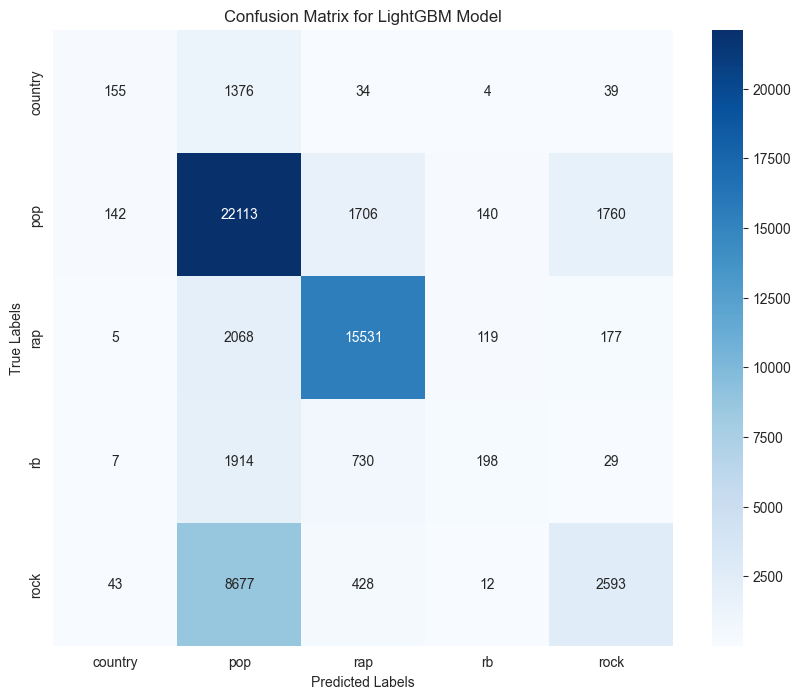

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_lgbm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for LightGBM Model')
plt.show()

In [38]:
# Save the trained LightGBM model
joblib.dump(lightgbm_model, 'models/lightgbm_model.pkl')

['models/lightgbm_model.pkl']

Model 2: Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train the Random Forest model
random_forest_model = RandomForestClassifier(random_state=77)
random_forest_model.fit(X_train, y_train)  # Train the model

# Make predictions
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.6632
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.01      0.02      1608
           1       0.59      0.89      0.71     25861
           2       0.84      0.84      0.84     17900
           3       0.43      0.00      0.01      2878
           4       0.57      0.15      0.24     11753

    accuracy                           0.66     60000
   macro avg       0.58      0.38      0.36     60000
weighted avg       0.65      0.66      0.60     60000



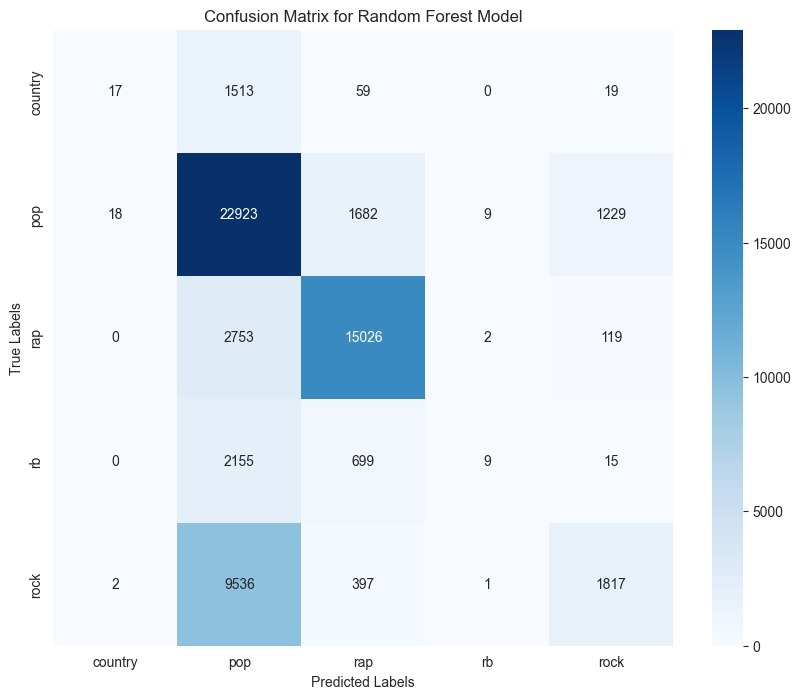

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [42]:
# Save the trained Random Forest model
joblib.dump(random_forest_model, 'models/random_forest_model.pkl')

['models/random_forest_model.pkl']

Model 3: XGradientBoost

In [43]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train the XGradientBoost model
xgboost_model = XGBClassifier(random_state=77)
xgboost_model.fit(X_train, y_train)  # Train the model

# Make predictions
y_pred_xgboost = xgboost_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_xgboost)
print(f"XGradientBoost Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_xgboost))

XGradientBoost Accuracy: 0.6759
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.10      0.16      1608
           1       0.61      0.85      0.71     25861
           2       0.84      0.87      0.86     17900
           3       0.40      0.07      0.12      2878
           4       0.55      0.23      0.33     11753

    accuracy                           0.68     60000
   macro avg       0.59      0.42      0.43     60000
weighted avg       0.66      0.68      0.64     60000



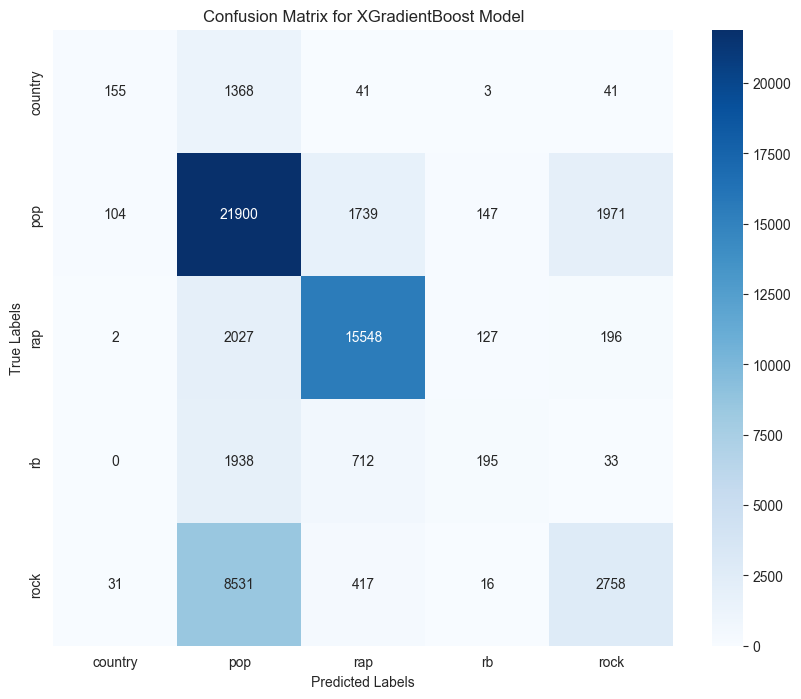

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgboost)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for XGradientBoost Model')
plt.show()

In [46]:
# Save the trained XGradientBoost model
joblib.dump(xgboost_model, 'models/xgboost_model.pkl')

['models/xgboost_model.pkl']